In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
df = pd.read_csv('STB.csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06/01/2018,11750,11700,12000,11700,4.31M,0.0000
1,06/04/2018,12550,12000,12550,12000,7.42M,0.0681
2,06/05/2018,12900,12700,13150,12600,8.11M,0.0279
3,06/06/2018,13300,12800,13450,12700,8.48M,0.0310
4,06/07/2018,13000,13300,13350,12950,7.11M,-0.0226


In [ ]:
# Take AR Model of lag = 3, 2 differencing for stationary
train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train_data = df['Price'].iloc[:train_size]
test_data =  df['Price'].iloc[train_size:]

In [ ]:
from pmdarima.arima import auto_arima
best_arima = auto_arima(train_data,trace=True)
best_arima.fit(train_data)
print(best_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12879.447, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12872.918, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12874.726, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12874.725, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12872.819, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12876.550, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.280 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  869
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6435.410
Date:                Fri, 16 Jun 2023   AIC                          12872.819
Time:                        22:03:41   BIC                          12877.586
Sample:                             0   HQIC                         12874.643
    

In [ ]:
# summary of fit model
arimax_train = df[['Price','High']].iloc[:train_size]
arimax_test = df[['Price','High']].iloc[train_size:]
arimax_model = ARIMA(arimax_train['Price'],exog=arimax_train['High'],order=(0,1,0))
arimax_fitted = arimax_model.fit()
print(arimax_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  869
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -6218.629
Date:                Fri, 16 Jun 2023   AIC                          12441.259
Time:                        22:03:44   BIC                          12450.791
Sample:                             0   HQIC                         12444.907
                                - 869                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
High           0.7047      0.017     41.763      0.000       0.672       0.738
sigma2      9.781e+04   1929.133     50.700      0.000     9.4e+04    1.02e+05
Ljung-Box (L1) (Q):                 186.43   Jarque-

In [ ]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred_arimax= arimax_fitted.predict(start=len(df)-test_size,end=len(df)-1,exog= arimax_test['High'])

# 5. Quá trình Validate
x_val= np.array(df['Price'].index).reshape(-1, 1)
y_val = np.array(df['Price'])
y_pred_val_arimax =  arimax_fitted.predict(start=0,end=train_size-1,exog=arimax_train['High'])
y_pred_val_arimax = pd.concat([y_pred_val_arimax,y_pred_arimax])

ARIMAX Validation RMSE: 928.1861207125875
ARIMAX Testing RMSE: 1616.1682995517606
Validation MAPE: 2.6584149498136815
Testing MAPE: 5.8904377985253555
Validation MAE: 530.680217172601
Testing MAE: 1304.1415310191367


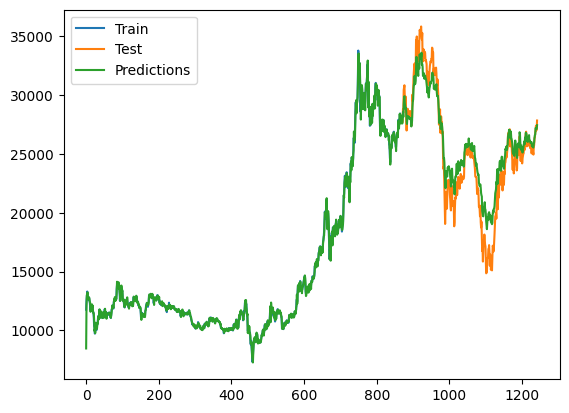

In [ ]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val_arimax - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_arimax - y_test)**2))
print('ARIMAX Validation RMSE:', valid_rmse)
print('ARIMAX Testing RMSE:', test_rmse)

valid_mape = np.mean(np.abs((y_pred_val_arimax - y_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_pred_arimax - y_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

valid_mae = np.mean(np.abs(y_pred_val_arimax - y_val))
test_mae = np.mean(np.abs(y_pred_arimax - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

# 9.Vẽ hình
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(df['Price'].index, y_pred_val_arimax)
# plt.plot(last_data,y_next_10_arima)
plt.legend(['Train', 'Test', 'Predictions','Validate'])
plt.show()